In [18]:
from tensorflow import keras
import tensorflow as tf
import os
import pathlib
import numpy as np
import PIL
import PIL.Image


In [19]:
path = '/home/bhavik/projects/compVision/Fruit-Sorter/dataset/Kesar'
data_dir = pathlib.Path(path)
data_dir


PosixPath('/home/bhavik/projects/compVision/Fruit-Sorter/dataset/Kesar')

In [20]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count


826

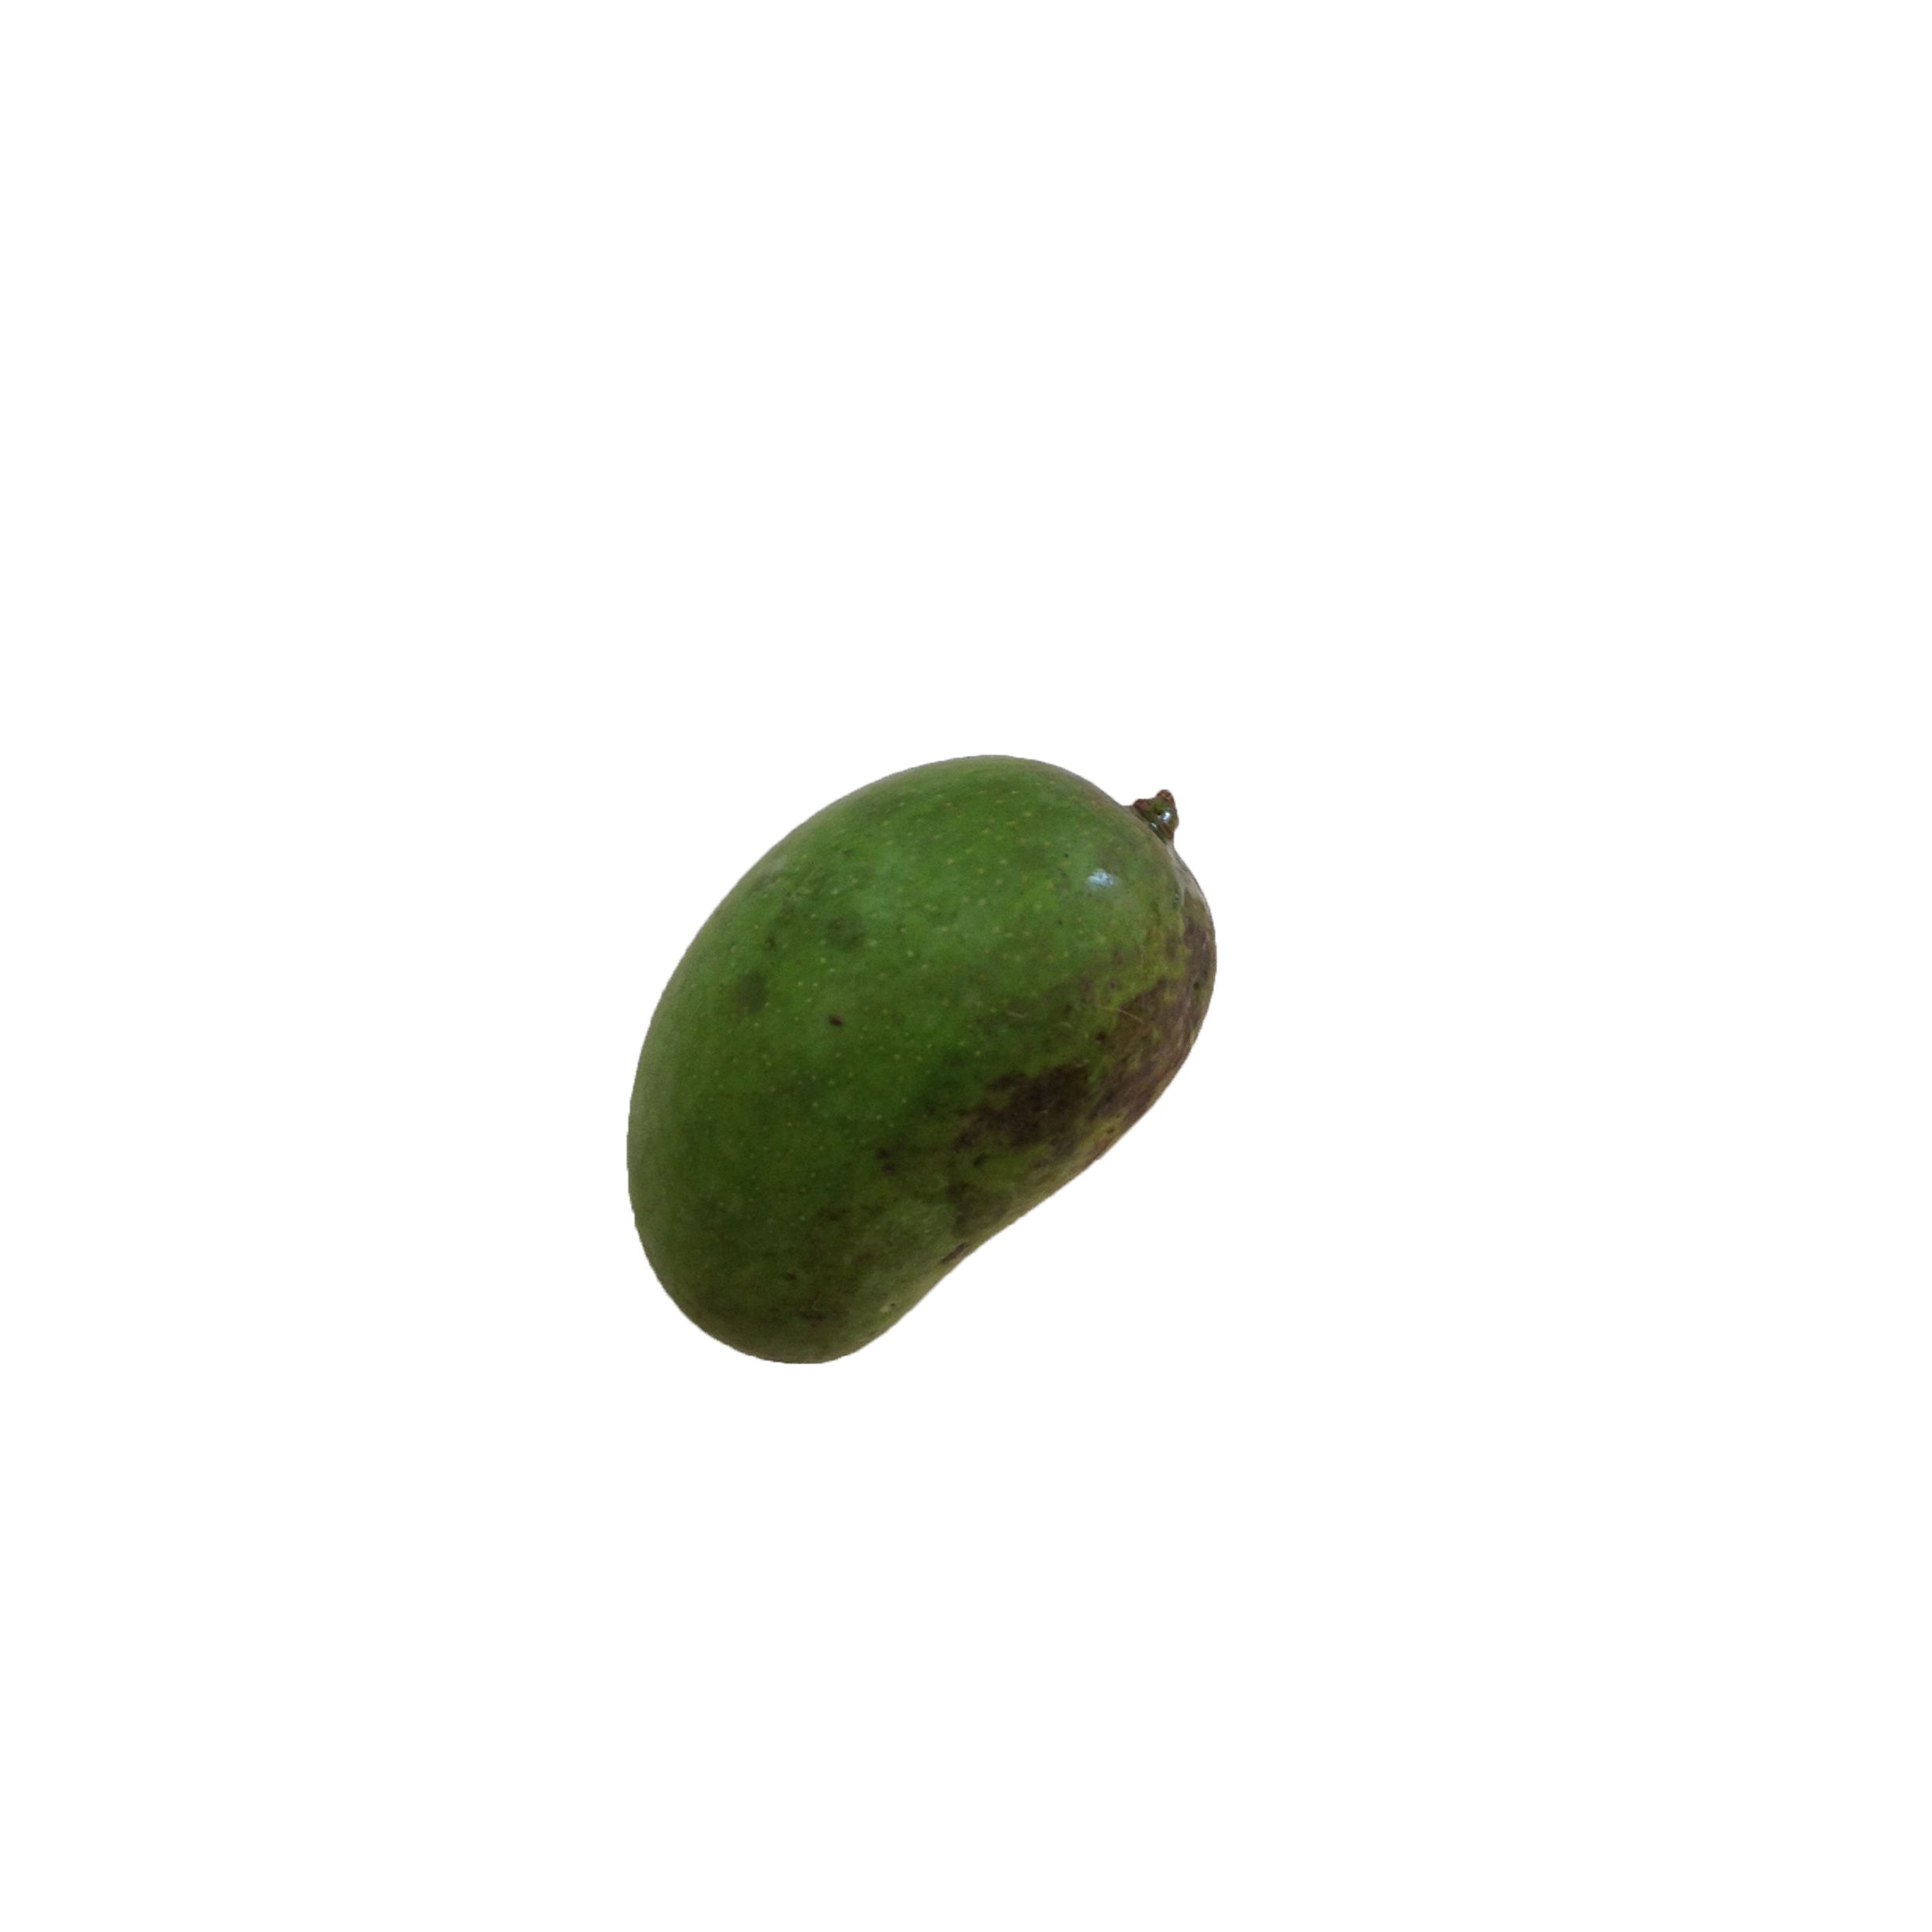

In [21]:
small = list(data_dir.glob('Small/*'))
PIL.Image.open(str(small[0]))


In [24]:
import matplotlib.pyplot as plt
img = plt.imread(str(small[0]))
img[1, 1, 0]


255

In [25]:
batch_size = 32
img_height = 180
img_width = 180


In [26]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 826 files belonging to 3 classes.
Using 661 files for training.


In [27]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 826 files belonging to 3 classes.
Using 165 files for validation.


In [28]:
class_names = train_ds.class_names
print(class_names)

['Big', 'Medium', 'Small']


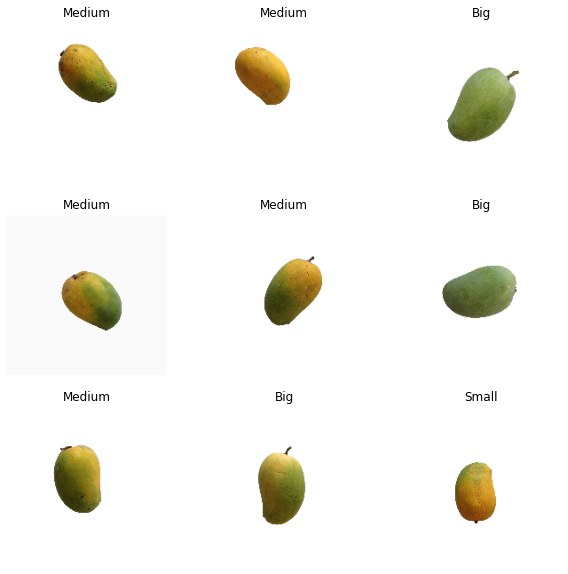

In [29]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [30]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [31]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.012431048 1.0


In [32]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [33]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [34]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [37]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1,
                               save_best_only=True)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[checkpointer]
)


Epoch 1/3
21/21 [==============================] - 14s 660ms/step - loss: 0.6972 - accuracy: 0.6793 - val_loss: 0.6861 - val_accuracy: 0.6485

Epoch 00001: val_loss improved from inf to 0.68610, saving model to model.weights.best.hdf5
Epoch 2/3
21/21 [==============================] - 14s 649ms/step - loss: 0.5832 - accuracy: 0.7458 - val_loss: 0.6521 - val_accuracy: 0.7152

Epoch 00002: val_loss improved from 0.68610 to 0.65206, saving model to model.weights.best.hdf5
Epoch 3/3
21/21 [==============================] - 13s 640ms/step - loss: 0.5389 - accuracy: 0.7655 - val_loss: 0.6647 - val_accuracy: 0.7152

Epoch 00003: val_loss did not improve from 0.65206


In [41]:
score = model.evaluate(val_ds)
accuracy = score[1]*100
print('accuracy of model : ', accuracy)

6/6 [==============================] - 1s 112ms/step - loss: 0.6647 - accuracy: 0.7152
accuracy of model :  71.51514887809753
